In [ ]:
import sys
sys.executable


sys.path

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
#from tensorflow.keras.utils.vis_utils import plot_model
from tensorflow.keras import layers, preprocessing, callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from IPython.display import Image
import matplotlib.cm as cm
from tensorflow.keras.applications import ResNet50, VGG16
import datetime, os
import numpy as np
import seaborn as sn
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight

%load_ext tensorboard

In [2]:
# Important variables
EPOCHS = 50

TRAIN_DIR = "C:/Users\Joelr/Keras_EPQ/x_rays/train"
TEST_DIR = "C:/Users\Joelr/Keras_EPQ/x_rays/test"
PRED_DIR = "C:/Users/Joelr/Keras_EPQ/x_rays/prediction"

BATCH_SIZE = 16

IMG_HEIGHT = 150
IMG_WIDTH = 150

CLASSES = ["0","1","2","3","4"]


In [4]:
# Data preprocessing

train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=5,
    width_shift_range=2.0,
    height_shift_range=2.0,
    zoom_range=0.125,
    channel_shift_range=0.0, #was 3.0
    fill_mode="nearest",
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1./255
)

test_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)



train_data_gen = train_gen.flow_from_directory(directory= TRAIN_DIR,
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = CLASSES)

test_data_gen = test_gen.flow_from_directory(directory= TEST_DIR,
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=False,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = CLASSES)


pred_data_gen = test_gen.flow_from_directory(directory= PRED_DIR,
                                                     batch_size= 18 ,
                                                     shuffle=False,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = "0")


 
# Alter class weights to to counter imbalance

weight = class_weight.compute_class_weight(
               'balanced',
                np.unique(train_data_gen.classes), 
                train_data_gen.classes)

CLASS_WEIGHTS = dict(enumerate(weight))

Found 7392 images belonging to 5 classes.
Found 462 images belonging to 5 classes.
Found 18 images belonging to 1 classes.


c:\users\joelr\anaconda3\envs\gamer\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1 2 3 4], y=[0 0 0 ... 4 4 4] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [5]:
# Define model

base = tf.keras.applications.InceptionResNetV2(
    include_top=False,
    weights="imagenet",
    input_tensor=Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)))

# Take output from pre-trained and put through custom classifier
x = base.output
x = tf.keras.layers.GlobalMaxPooling2D()(x)
x =tf.keras.layers.Dense(1024, activation='relu')(x)
x =tf.keras.layers.Dense(512, activation='relu')(x)
x =tf.keras.layers.Dense(64, activation='relu')(x)
output = tf.keras.layers.Dense(5, activation='softmax')(x) #OUtput is an array of probabilities 0-1

model = Model(inputs=base.input, outputs=output)

In [7]:
for i, layer in enumerate(model.layers):
    if i < 103:
        layer.trainable = False
    else:
        layer.trainable = True
    print(i, layer.name, layer.trainable)

model.summary()
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
#model.compile(optimizer=SGD(learning_rate=0.001), loss='categorical_crossentropy', metrics=['acc'])
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['acc'])

0 input_1 False
1 conv2d False
2 batch_normalization False
3 activation False
4 conv2d_1 False
5 batch_normalization_1 False
6 activation_1 False
7 conv2d_2 False
8 batch_normalization_2 False
9 activation_2 False
10 max_pooling2d False
11 conv2d_3 False
12 batch_normalization_3 False
13 activation_3 False
14 conv2d_4 False
15 batch_normalization_4 False
16 activation_4 False
17 max_pooling2d_1 False
18 conv2d_8 False
19 batch_normalization_8 False
20 activation_8 False
21 conv2d_6 False
22 conv2d_9 False
23 batch_normalization_6 False
24 batch_normalization_9 False
25 activation_6 False
26 activation_9 False
27 average_pooling2d False
28 conv2d_5 False
29 conv2d_7 False
30 conv2d_10 False
31 conv2d_11 False
32 batch_normalization_5 False
33 batch_normalization_7 False
34 batch_normalization_10 False
35 batch_normalization_11 False
36 activation_5 False
37 activation_7 False
38 activation_10 False
39 activation_11 False
40 mixed_5b False
41 conv2d_15 False
42 batch_normalization_15 Fal

In [6]:
#Train

#Line 5 from https://www.tensorflow.org/tensorboard/get_started

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, write_graph=True)


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5,
                              min_lr=0,
                              cooldown=0,
                              min_delta=0.001,
                              verbose=1)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.1,
    patience=15,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

callbacks = [tensorboard_callback, reduce_lr]

model.fit(x = train_data_gen,
         epochs = EPOCHS,
         validation_data = test_data_gen,
          callbacks=callbacks,
          class_weight = CLASS_WEIGHTS
         )


Epoch 1/50
  1/462 [..............................] - ETA: 0s - loss: 1.3192 - acc: 0.1875WARNING:tensorflow:From c:\users\joelr\anaconda3\envs\gamer\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
462/462 [==============================] - 87s 189ms/step - loss: 1.5705 - acc: 0.2550 - val_loss: 1.7126 - val_acc: 0.3896
Epoch 2/50
462/462 [==============================] - 75s 163ms/step - loss: 1.2038 - acc: 0.3454 - val_loss: 3.3200 - val_acc: 0.2143
Epoch 3/50
462/462 [==============================] - 75s 162ms/step - loss: 1.0995 - acc: 0.3896 - val_loss: 1.2174 - val_acc: 0.4762
Epoch 4/50
462/462 [==============================] - 76s 165ms/step - loss: 0.9584 - acc: 0.4651 - val_loss: 1.5385 - val_acc: 0.4372
Epoch 5/50
462/462 [==============================] - 77s 167ms/step - loss: 0.9510 - ac

In [7]:
#model.save("InceptionResnetV2 Final.h5",include_optimizer=True)

In [6]:
model = load_model("InceptionResnetV2 low recal.h5")

In [8]:
preds_array = model.predict(test_data_gen)
preds = np.argmax(preds_array, axis=1)

conf_mat = confusion_matrix(test_data_gen.classes, preds)
print('Confusion Matrix')
print(conf_mat,"\n")
print('Classification Report')
print(classification_report(test_data_gen.classes, preds, target_names=CLASSES))

# Precision = True Positives / True Positives + False Positives i.e. Out of all the knees labelled as 4, how many were actually 4
# Recall = True Pos / True pos + False neg i.e. Out of all the knees that were actually 4, how many were labelled 4

Confusion Matrix
[[83 16  1  0  0]
 [47 35 18  0  0]
 [ 8 22 59 11  0]
 [ 0  3  8 83  6]
 [ 0  0  0  6 56]] 

Classification Report
              precision    recall  f1-score   support

           0       0.60      0.83      0.70       100
           1       0.46      0.35      0.40       100
           2       0.69      0.59      0.63       100
           3       0.83      0.83      0.83       100
           4       0.90      0.90      0.90        62

    accuracy                           0.68       462
   macro avg       0.70      0.70      0.69       462
weighted avg       0.68      0.68      0.68       462



In [9]:
#Heatmap of confusion matrix

%matplotlib
sn.heatmap(conf_mat, annot=True, 
            fmt='', cmap='Blues')


plt.ylabel('True')
plt.xlabel('Predicted')
b, t = plt.ylim()
b += 0.5 
t -= 0.5 
plt.ylim(b, t)
plt.show() 

Using matplotlib backend: TkAgg


c:\users\joelr\anaconda3\envs\gamer\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


IndexError: index 16 is out of bounds for axis 0 with size 16

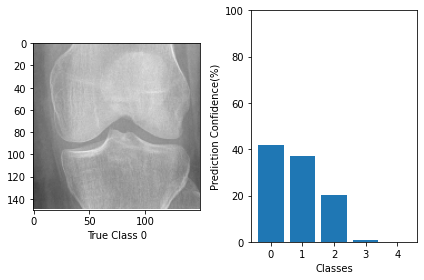

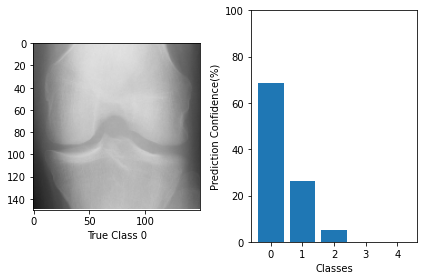

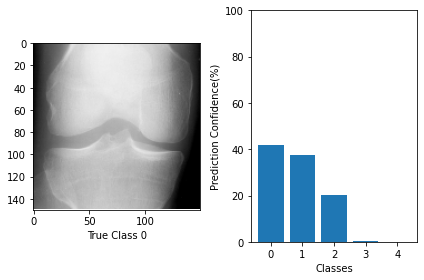

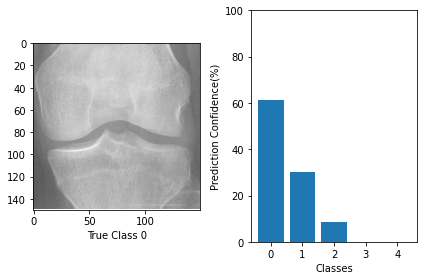

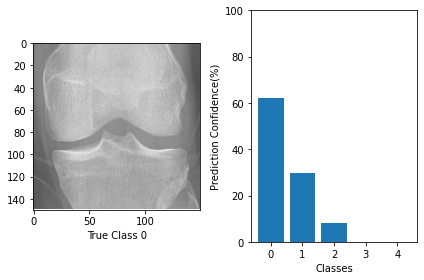

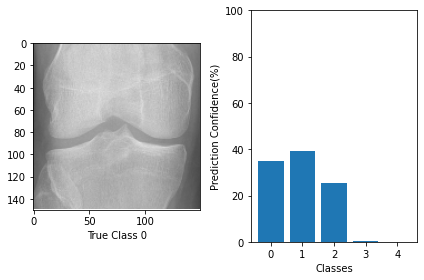

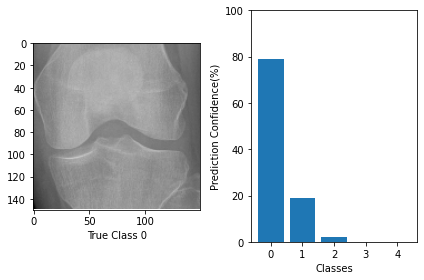

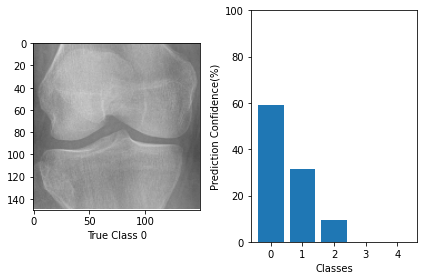

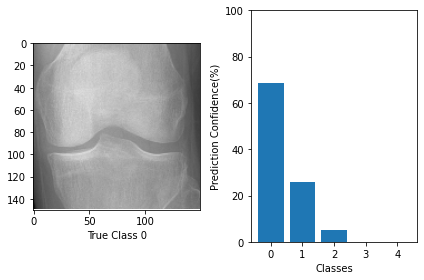

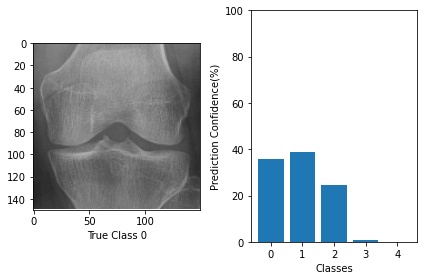

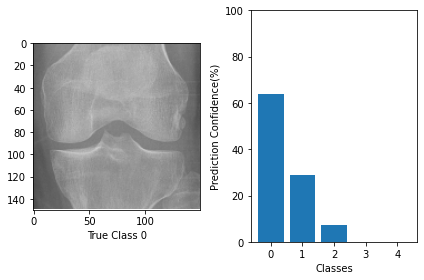

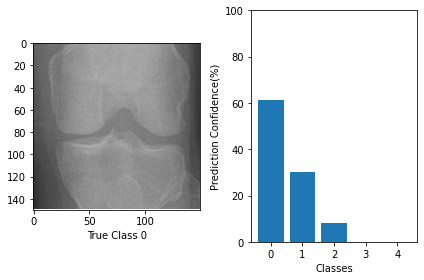

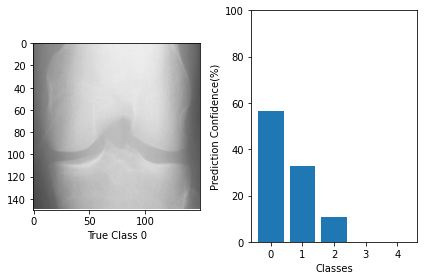

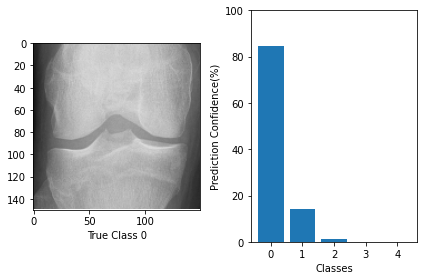

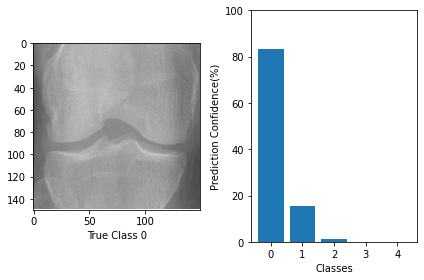

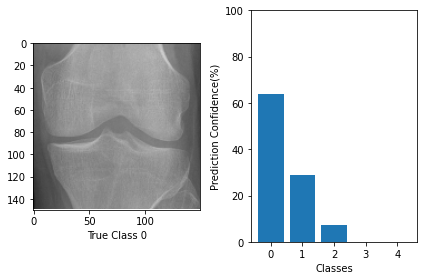

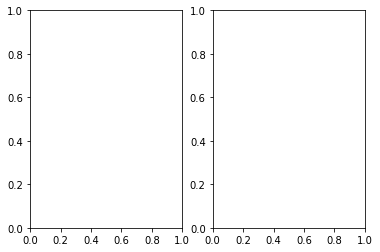

In [12]:
#Gives % confidence predictions and shows on bar chart.
x, y = test_data_gen.next()
pred_array = model.predict(x)
y = np.argmax(y, axis=1)

for i in range(BATCH_SIZE):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    
    ax1.imshow(x[i])
    label = "True Class " + str(y[i] )
    ax1.set_xlabel(label)

    ax2.bar(CLASSES, pred_array[i]*100, width=0.8, bottom=None, align='center', data=None)
    ax2.set_ylim([0,100])
    ax2.set_ylabel('Prediction Confidence(%)')
    ax2.set_xlabel("Classes")
    
    fig.tight_layout()
    fig.show()

In [ ]:
#Grad CAM from https://keras.io/examples/vision/grad_cam/#the-gradcam-algorithm

img_size = (150, 150)

last_conv_layer_name = "conv_7b"

classifier_layer_names = [
    "global_max_pooling2d",
    "dense",
    "dense_1",
    "dense_2",
    "dense_3"
]

img_path = "C://Users//Joelr//Keras_EPQ//x_rays//test//2//9024940R.png"


display(Image(img_path))

In [ ]:
#Grad CAM from https://keras.io/examples/vision/grad_cam/#the-gradcam-algorithm


def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

In [ ]:
#Grad CAM from https://keras.io/examples/vision/grad_cam/#the-gradcam-algorithm


img_array = get_img_array(img_path, size=img_size)

# Make model

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:",np.argmax(preds[0]))

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
)

# Display heatmap
plt.matshow(heatmap)
plt.show()

In [ ]:
#Grad CAM from https://keras.io/examples/vision/grad_cam/#the-gradcam-algorithm

def CAM(img_path):
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)
    
    img_array = get_img_array(img_path, size=img_size)
    
    preds = model.predict(img_array)
    print("Predicted:",np.argmax(preds[0]))
    
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names)

    # We rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # We use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # We create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.4 + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    save_path = "C:/Users/Joelr/Keras_EPQ/CAM/IncepV2/" + img_path[37] + "/" + img_path[39:]
    superimposed_img.save(save_path)

    # Display Grad CAM
    display(Image(save_path))

In [ ]:
#Dont use this a lot

import glob
files = glob.glob("C:/Users/Joelr/Keras_EPQ/x_rays/test/1/*.png")

# 37 index for class  39 index onwards for name

x = 0
for file in files:
    CAM(file)
    if x > 10:
        break
    x += 1
